In [1]:
import tensorflow as tf
import numpy as np
import datetime
import matplotlib.pyplot as plt
import datetime
%matplotlib inline

In [2]:
from tensorflow.examples.tutorials.mnist import input_data

In [3]:
mnist_data = input_data.read_data_sets('MNIST_data/')

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


(1, 784)


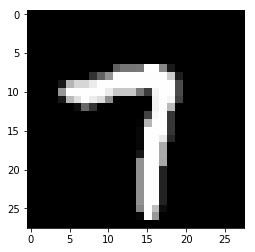

In [4]:
sample_image = mnist_data.train.next_batch(1)[0]
print(sample_image.shape)
sample_image = sample_image.reshape([28,28])
plt.imshow(sample_image, cmap='gray')

In [5]:
def discriminator(images, reuse=False):
    with tf.variable_scope(tf.get_variable_scope(), reuse=reuse) as scope:
    
        # First Convolutional and pool layers
        # This finds 32 different 5*5 features
        d_w1 = tf.get_variable('d_w1', [5, 5, 1, 32], initializer=tf.truncated_normal_initializer(stddev=0.02))
        d_b1 = tf.get_variable('d_b1', [32], initializer=tf.constant_initializer(0))
        d1 = tf.nn.conv2d(input=images, filter=d_w1, strides=[1,1,1,1], padding='SAME')
        d1 = d1 + d_b1
        d1 = tf.nn.relu(d1)
        d1 = tf.nn.avg_pool(d1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

        # Second Convolutional layer
        d_w2 = tf.get_variable('d_w2', [5, 5, 32, 64], initializer=tf.truncated_normal_initializer(stddev=0.02))
        d_b2 = tf.get_variable('d_b2', [64], initializer=tf.constant_initializer(0))
        d2 = tf.nn.conv2d(input=d1, filter=d_w2, strides=[1,1,1,1], padding='SAME')
        d2 = d2 + d_b2
        d2 = tf.nn.relu(d2)
        d2 = tf.nn.avg_pool(d2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

        # First Fully Connected layer
        d_w3 = tf.get_variable('d_w3', [7*7*64, 1024], initializer=tf.truncated_normal_initializer(stddev=0.02))
        d_b3 = tf.get_variable('d_b3', [1024], initializer=tf.constant_initializer(0))
        d3 = tf.reshape(d2, [-1, 7*7*64]) # Flatten
        d3 = tf.matmul(d3, d_w3)
        d3 = d3 + d_b3
        d3 = tf.nn.relu(d3)

        # Last Output layer
        d_w4 = tf.get_variable('d_w4', [1024, 1], initializer=tf.truncated_normal_initializer(stddev=0.02))
        d_b4 = tf.get_variable('d_b4', [1], initializer=tf.constant_initializer(0))
        d4 = tf.matmul(d3, d_w4) + d_b4

        return d4
    

In [6]:
def generator(z, batch_size, z_dim):
    g_w1 = tf.get_variable('g_w1', [z_dim, 3136], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02)) # 3136 = 28*28*2*2
    g_b1 = tf.get_variable('g_b1', [3136], initializer=tf.truncated_normal_initializer(stddev=0.02))
    g1 = tf.matmul(z, g_w1) + g_b1
    g1 = tf.reshape(g1, [-1, 56, 56, 1])
    g1 = tf.contrib.layers.batch_norm(g1, epsilon=1e-5, scope='bn1')
    g1 = tf.nn.relu(g1)
    
    # Generate 50 features
    g_w2 = tf.get_variable('g_w2', [3, 3, 1, z_dim/2], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
    g_b2 = tf.get_variable('g_b2', [z_dim/2], initializer=tf.truncated_normal_initializer(stddev=0.02))
    g2 = tf.nn.conv2d(g1, g_w2, strides=[1, 2, 2, 1], padding='SAME')
    g2 = g2 + g_b2
    g2 = tf.contrib.layers.batch_norm(g2, epsilon=1e-5, scope='bn2')
    g2 = tf.nn.relu(g2)
    g2 = tf.image.resize_images(g2, [56, 56])
    
    # Generate 25 features
    g_w3 = tf.get_variable('g_w3', [3, 3, z_dim/2, z_dim/4], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
    g_b3 = tf.get_variable('g_b3', [z_dim/4], initializer=tf.truncated_normal_initializer(stddev=0.02))
    g3 = tf.nn.conv2d(g2, g_w3, strides=[1,2,2,1], padding='SAME')
    g3 = g3 + g_b3
    g3 = tf.contrib.layers.batch_norm(g3, epsilon=1e-5, scope='bn3')
    g3 = tf.nn.relu(g3)
    g3 = tf.image.resize_images(g3, [56, 56])
    
    # Final convolution with one output channel
    g_w4 = tf.get_variable('g_w4', [1, 1, z_dim/4, 1], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
    g_b4 = tf.get_variable('g_b4', [1], initializer=tf.truncated_normal_initializer(stddev=0.02))
    g4 = tf.nn.conv2d(g3, g_w4, strides=[1, 2, 2, 1], padding='SAME')
    g4 = g4 + g_b4
    g4 = tf.sigmoid(g4)
    
    # Dimension of g4: batch_size * 28 * 28 * 1
    return g4

## Sample Image Generating

In [7]:
z_dimensions = 100 
z_placeholder = tf.placeholder(tf.float32, [None, z_dimensions])

In [8]:
generated_image_output = generator(z_placeholder, 1, z_dimensions)
z_batch = np.random.normal(0, 1, [1, z_dimensions])

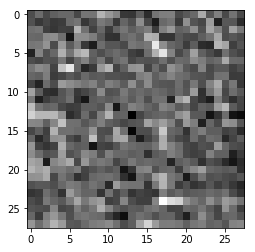

In [9]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    generated_image = sess.run(generated_image_output, feed_dict={z_placeholder:z_batch})
    generated_image = generated_image.reshape([28, 28])
    plt.imshow(generated_image, cmap='gray')

## Training GAN with MNIST

In [10]:
tf.reset_default_graph()
batch_size = 50

# z_placeholder is for feeding input noise to the "generator"
z_placeholder = tf.placeholder(tf.float32, [None, z_dimensions], name='z_placeholder')
# x_placeholder is for feeding input images to the "discriminator"
x_placeholder = tf.placeholder(tf.float32, [None, 28, 28, 1], name='x_placeholder')

# Gz holds the generated images
Gz = generator(z_placeholder, batch_size, z_dimensions)

# Dx will hold discriminator prediction probabilities
# for the real MNIST images
Dx = discriminator(x_placeholder)

# Dg will hold discriminator prediction probabilities for generated images
Dg = discriminator(Gz, reuse=True)

### Define Discriminator Loss Function

In [11]:
# Compare real images loss probabilities : 1 <-> Dx output
# tf.ones_like : Make same shape of 1 matrix
d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Dx, labels=tf.ones_like(Dx)))

# Compare fake images loss probabilities : 0 <-> Dg outut
d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Dg, labels=tf.zeros_like(Dg)))

### Define Generator Loss Function

In [12]:
# generator wants the discriminator to output a value close to 1 when it's given an image from the generator
g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Dg, labels=tf.ones_like(Dg)))

### Figure out training variables

In [13]:
tvars = tf.trainable_variables()
d_tvars = [var for var in tvars if 'd_' in var.name]
g_tvars = [var for var in tvars if 'g_' in var.name]

print(d_tvars)
print(g_tvars)

[<tf.Variable 'd_w1:0' shape=(5, 5, 1, 32) dtype=float32_ref>, <tf.Variable 'd_b1:0' shape=(32,) dtype=float32_ref>, <tf.Variable 'd_w2:0' shape=(5, 5, 32, 64) dtype=float32_ref>, <tf.Variable 'd_b2:0' shape=(64,) dtype=float32_ref>, <tf.Variable 'd_w3:0' shape=(3136, 1024) dtype=float32_ref>, <tf.Variable 'd_b3:0' shape=(1024,) dtype=float32_ref>, <tf.Variable 'd_w4:0' shape=(1024, 1) dtype=float32_ref>, <tf.Variable 'd_b4:0' shape=(1,) dtype=float32_ref>]
[<tf.Variable 'g_w1:0' shape=(100, 3136) dtype=float32_ref>, <tf.Variable 'g_b1:0' shape=(3136,) dtype=float32_ref>, <tf.Variable 'g_w2:0' shape=(3, 3, 1, 50) dtype=float32_ref>, <tf.Variable 'g_b2:0' shape=(50,) dtype=float32_ref>, <tf.Variable 'g_w3:0' shape=(3, 3, 50, 25) dtype=float32_ref>, <tf.Variable 'g_b3:0' shape=(25,) dtype=float32_ref>, <tf.Variable 'g_w4:0' shape=(1, 1, 25, 1) dtype=float32_ref>, <tf.Variable 'g_b4:0' shape=(1,) dtype=float32_ref>]


### Apply Trainer

In [14]:
# Disciminator trainer
d_trainer_real = tf.train.AdamOptimizer(0.0003).minimize(d_loss_real, var_list=d_tvars)
d_trainer_fake = tf.train.AdamOptimizer(0.0003).minimize(d_loss_fake, var_list=d_tvars)

# Generator trainer
g_trainer = tf.train.AdamOptimizer(0.0001).minimize(g_loss, var_list=g_tvars)

In [15]:
tf.get_variable_scope().reuse_variables()

tf.summary.scalar('Generator_loss', g_loss)
tf.summary.scalar('Discriminator_loss_fake', d_loss_fake)
tf.summary.scalar('Discriminator_loss_real', d_loss_real)

images_for_tensorboard = generator(z_placeholder, batch_size, z_dimensions)
tf.summary.image('Generated_Image', images_for_tensorboard, 5)
merged = tf.summary.merge_all()

logdir = "tensorboard/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + '/'
writer = tf.summary.FileWriter(logdir, sess.graph)

In [16]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

for i in range(500):
    z_batch = np.random.normal(0, 1, [batch_size, z_dimensions])
    real_image_batch = mnist_data.train.next_batch(batch_size)[0].reshape([batch_size, 28, 28, 1])
    _, _, dLossReal, dLossFake = sess.run([d_trainer_real, d_trainer_fake, d_loss_real, d_loss_fake], 
                                          feed_dict={z_placeholder:z_batch, x_placeholder:real_image_batch})
    if i % 100 == 0:
        print("Discriminator loss Real : {}, loss Fake : {}".format(dLossReal, dLossFake))

Discriminator loss Real : 0.6935518980026245, loss Fake : 0.7156815528869629
Discriminator loss Real : 0.02105160430073738, loss Fake : 0.06410997360944748
Discriminator loss Real : 0.0038117594085633755, loss Fake : 0.0025210147723555565
Discriminator loss Real : 2.5289678887929767e-05, loss Fake : 6.847409531474113e-05
Discriminator loss Real : 2.484089054632932e-05, loss Fake : 2.6979701942764223e-05


In [18]:
saver = tf.train.Saver()

### Train generator and discriminator together

i : 0, at : 2017-09-07 11:00:57.183659


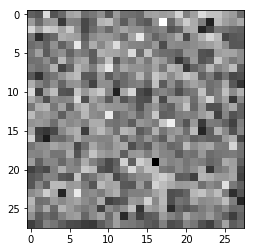

Estimated result : [[-11.17620564]]
i : 100, at : 2017-09-07 11:01:05.971398


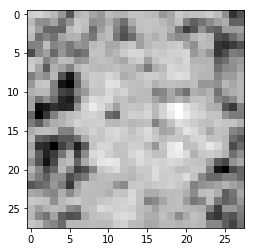

Estimated result : [[-10.54592514]]
i : 200, at : 2017-09-07 11:01:14.314449


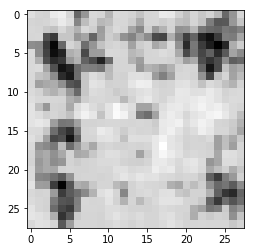

Estimated result : [[-9.27123642]]
i : 300, at : 2017-09-07 11:01:22.614747


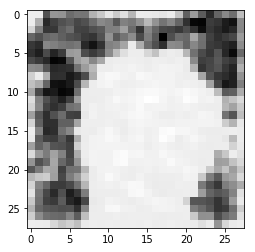

Estimated result : [[-8.61159897]]
i : 400, at : 2017-09-07 11:01:30.970381


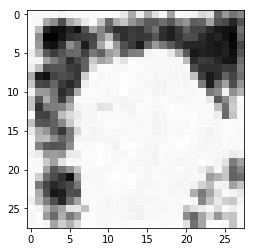

Estimated result : [[-7.65981007]]
i : 500, at : 2017-09-07 11:01:39.413325


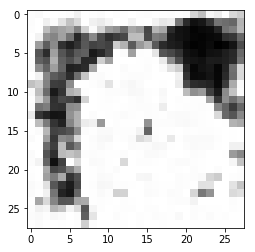

Estimated result : [[-12.22058392]]
i : 600, at : 2017-09-07 11:01:47.854305


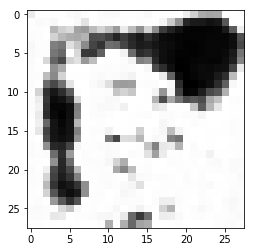

Estimated result : [[-10.33095837]]
i : 700, at : 2017-09-07 11:01:56.148042


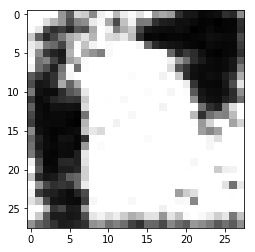

Estimated result : [[-10.32963562]]
i : 800, at : 2017-09-07 11:02:04.446324


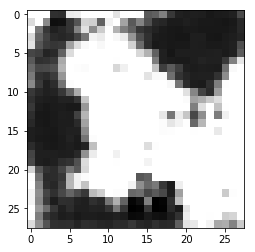

Estimated result : [[-6.47795868]]
i : 900, at : 2017-09-07 11:02:12.934949


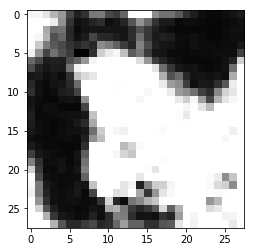

Estimated result : [[-8.1289978]]
i : 1000, at : 2017-09-07 11:02:21.247257


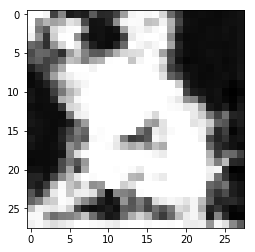

Estimated result : [[-4.52086115]]
i : 1100, at : 2017-09-07 11:02:29.555876


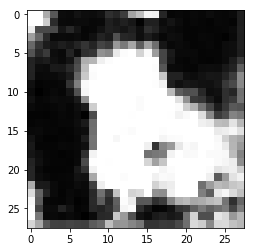

Estimated result : [[-3.04479551]]
i : 1200, at : 2017-09-07 11:02:37.982846


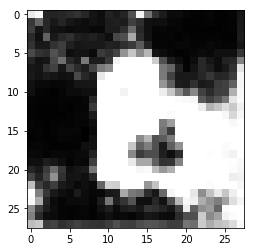

Estimated result : [[-5.24619389]]
i : 1300, at : 2017-09-07 11:02:46.358100


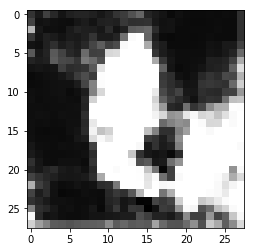

Estimated result : [[-6.57790041]]
i : 1400, at : 2017-09-07 11:02:54.756695


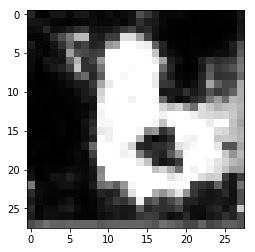

Estimated result : [[-4.40829659]]
i : 1500, at : 2017-09-07 11:03:03.112605


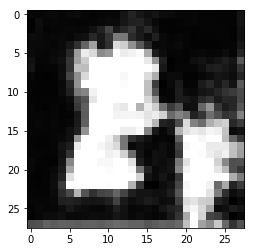

Estimated result : [[-7.40304661]]
i : 1600, at : 2017-09-07 11:03:11.440256


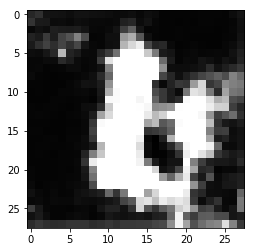

Estimated result : [[-7.39073992]]
i : 1700, at : 2017-09-07 11:03:19.845897


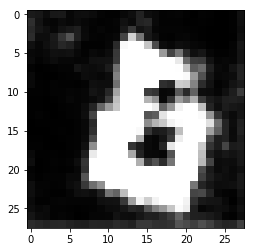

Estimated result : [[-5.91592407]]
i : 1800, at : 2017-09-07 11:03:28.193904


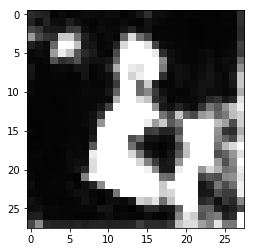

Estimated result : [[-7.84813738]]
i : 1900, at : 2017-09-07 11:03:36.656278


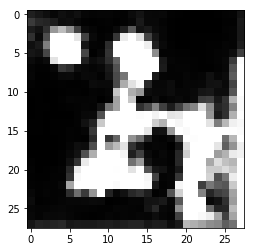

Estimated result : [[-3.50431204]]
i : 2000, at : 2017-09-07 11:03:45.137562


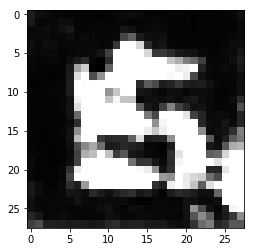

Estimated result : [[-6.27098036]]
i : 2100, at : 2017-09-07 11:03:53.523304


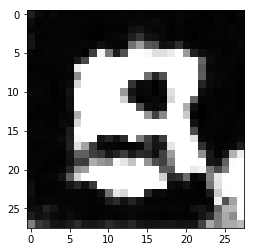

Estimated result : [[-4.79924011]]
i : 2200, at : 2017-09-07 11:04:01.970455


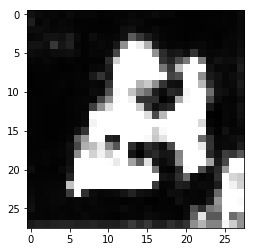

Estimated result : [[-6.55984497]]
i : 2300, at : 2017-09-07 11:04:10.323867


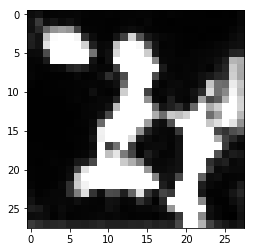

Estimated result : [[-4.20988417]]
i : 2400, at : 2017-09-07 11:04:18.791603


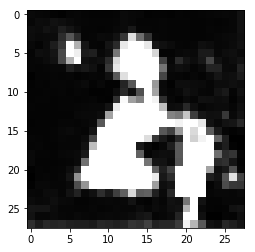

Estimated result : [[-5.09527826]]
i : 2500, at : 2017-09-07 11:04:27.152880


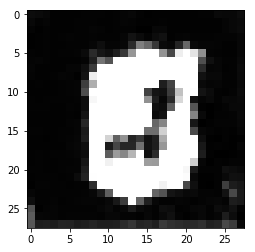

Estimated result : [[-3.41417217]]
i : 2600, at : 2017-09-07 11:04:35.602232


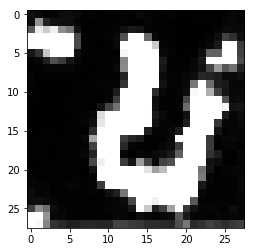

Estimated result : [[-4.30743933]]
i : 2700, at : 2017-09-07 11:04:44.111807


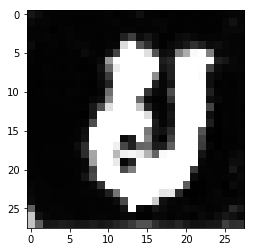

Estimated result : [[-5.11252308]]
i : 2800, at : 2017-09-07 11:04:52.589769


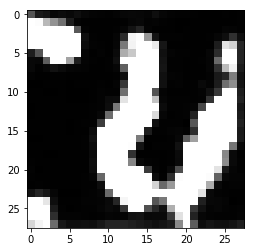

Estimated result : [[-3.13126135]]
i : 2900, at : 2017-09-07 11:05:00.962931


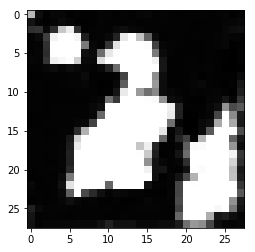

Estimated result : [[-5.35804939]]
i : 3000, at : 2017-09-07 11:05:09.353030


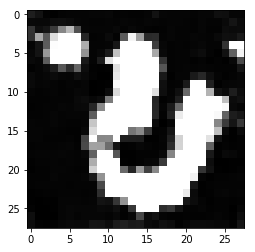

Estimated result : [[-6.5341506]]
i : 3100, at : 2017-09-07 11:05:17.756197


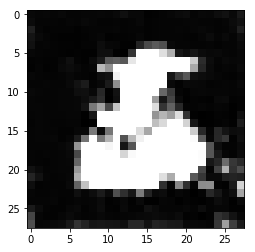

Estimated result : [[-6.50044203]]
i : 3200, at : 2017-09-07 11:05:26.166238


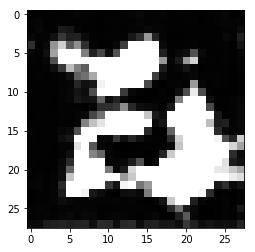

Estimated result : [[-6.72049618]]
i : 3300, at : 2017-09-07 11:05:34.578781


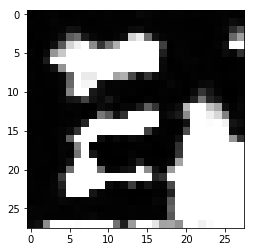

Estimated result : [[-5.32564211]]
i : 3400, at : 2017-09-07 11:05:43.086391


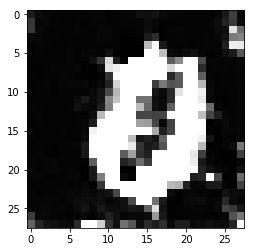

Estimated result : [[-7.75679588]]
i : 3500, at : 2017-09-07 11:05:51.640931


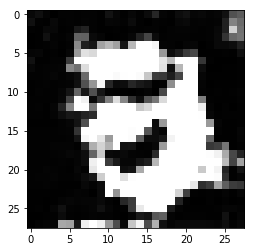

Estimated result : [[-13.80029202]]
i : 3600, at : 2017-09-07 11:06:00.034508


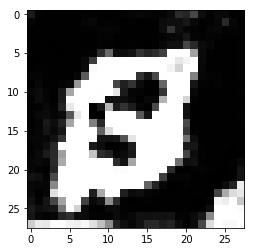

Estimated result : [[-10.49881935]]
i : 3700, at : 2017-09-07 11:06:08.544808


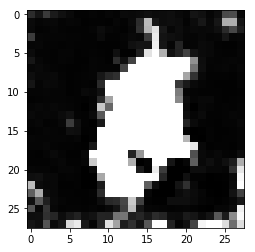

Estimated result : [[-18.1713028]]
i : 3800, at : 2017-09-07 11:06:16.985866


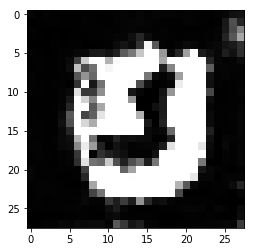

Estimated result : [[-7.29491234]]
i : 3900, at : 2017-09-07 11:06:25.588317


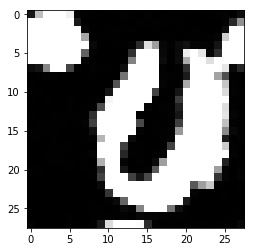

Estimated result : [[-8.58285522]]
i : 4000, at : 2017-09-07 11:06:34.028423


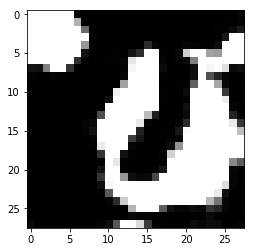

Estimated result : [[-9.71834087]]
i : 4100, at : 2017-09-07 11:06:42.456239


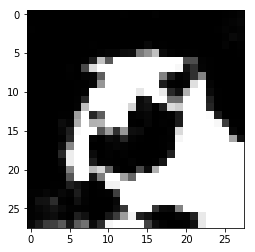

Estimated result : [[-9.61583996]]
i : 4200, at : 2017-09-07 11:06:50.876625


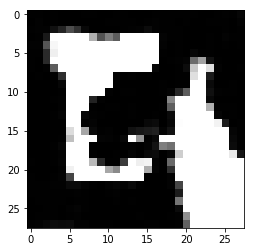

Estimated result : [[-6.39937305]]
i : 4300, at : 2017-09-07 11:06:59.320836


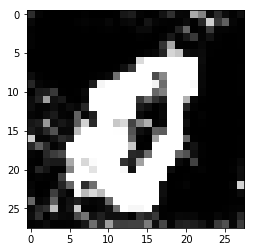

Estimated result : [[-25.38683128]]
i : 4400, at : 2017-09-07 11:07:07.824075


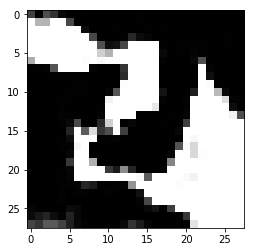

Estimated result : [[-12.56470013]]
i : 4500, at : 2017-09-07 11:07:16.517759


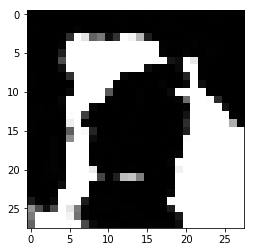

Estimated result : [[-12.12057781]]
i : 4600, at : 2017-09-07 11:07:24.981275


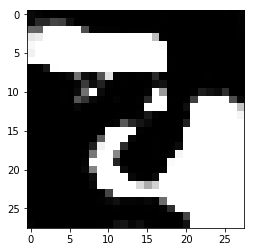

Estimated result : [[-24.95088196]]
i : 4700, at : 2017-09-07 11:07:33.443130


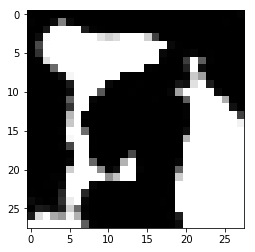

Estimated result : [[-1.24597216]]
i : 4800, at : 2017-09-07 11:07:41.986403


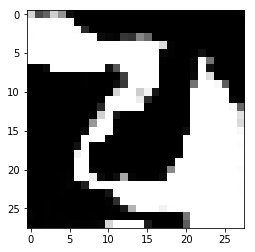

Estimated result : [[-22.19316292]]
i : 4900, at : 2017-09-07 11:07:50.535202


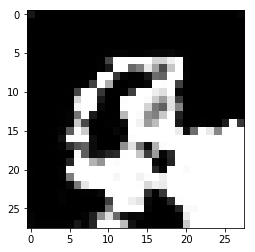

Estimated result : [[-8.24045658]]
i : 5000, at : 2017-09-07 11:07:59.114964


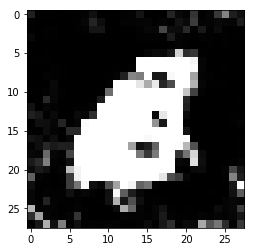

Estimated result : [[-44.14433289]]
i : 5100, at : 2017-09-07 11:08:07.582714


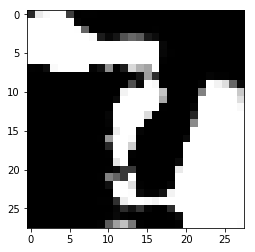

Estimated result : [[-6.19189644]]
i : 5200, at : 2017-09-07 11:08:16.031779


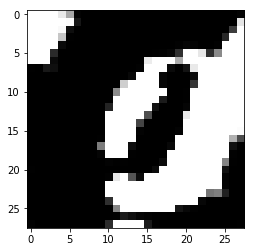

Estimated result : [[-36.21087646]]
i : 5300, at : 2017-09-07 11:08:24.616728


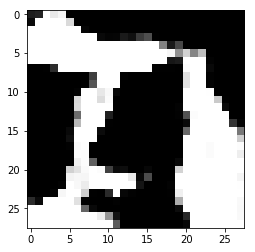

Estimated result : [[-4.43148232]]
i : 5400, at : 2017-09-07 11:08:33.103446


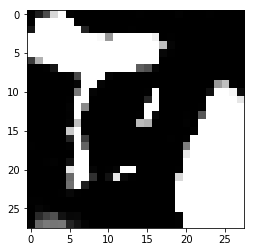

Estimated result : [[-7.26559639]]
i : 5500, at : 2017-09-07 11:08:41.612187


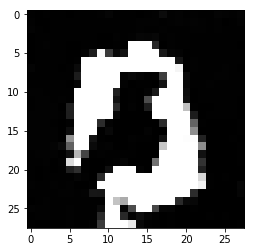

Estimated result : [[-20.57962227]]
i : 5600, at : 2017-09-07 11:08:50.304437


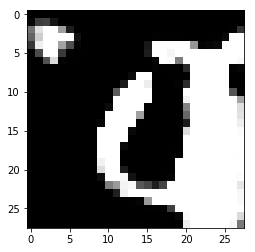

Estimated result : [[-22.57567024]]
i : 5700, at : 2017-09-07 11:08:58.838204


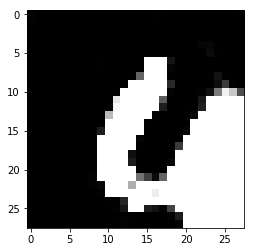

Estimated result : [[-11.74496269]]
i : 5800, at : 2017-09-07 11:09:07.334242


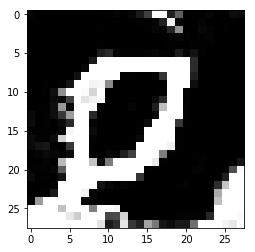

Estimated result : [[-27.93708611]]
i : 5900, at : 2017-09-07 11:09:15.878434


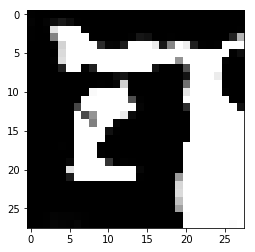

Estimated result : [[-7.47161961]]
i : 6000, at : 2017-09-07 11:09:24.374166


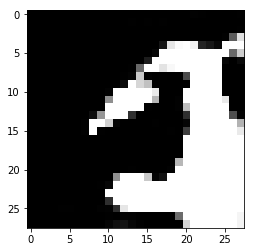

Estimated result : [[-8.62096024]]
i : 6100, at : 2017-09-07 11:09:32.967682


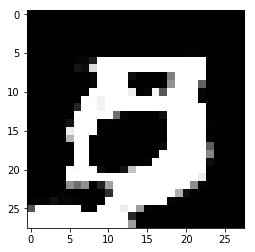

Estimated result : [[ 4.63491488]]
i : 6200, at : 2017-09-07 11:09:41.631841


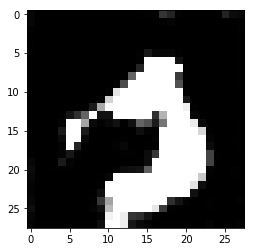

Estimated result : [[-16.42327309]]
i : 6300, at : 2017-09-07 11:09:50.175641


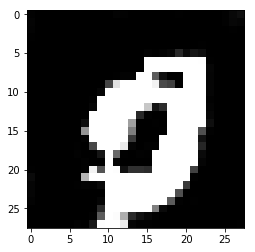

Estimated result : [[-13.0895443]]
i : 6400, at : 2017-09-07 11:09:58.768106


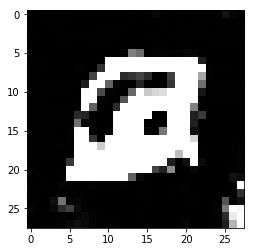

Estimated result : [[-29.73074532]]
i : 6500, at : 2017-09-07 11:10:07.408516


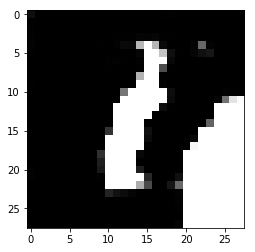

Estimated result : [[-48.42725372]]
i : 6600, at : 2017-09-07 11:10:15.939845


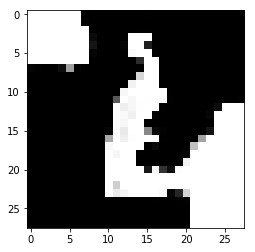

Estimated result : [[ 5.78030491]]
i : 6700, at : 2017-09-07 11:10:24.558870


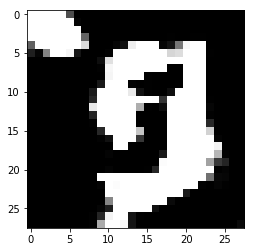

Estimated result : [[-15.64561653]]
i : 6800, at : 2017-09-07 11:10:33.205583


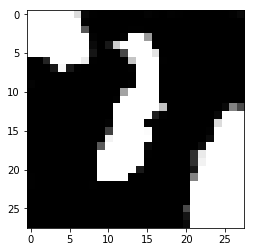

Estimated result : [[-12.2750988]]
i : 6900, at : 2017-09-07 11:10:41.939050


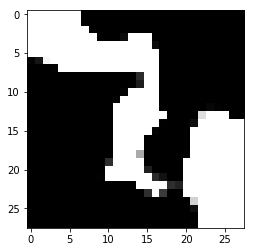

Estimated result : [[-9.80481625]]
i : 7000, at : 2017-09-07 11:10:50.514544


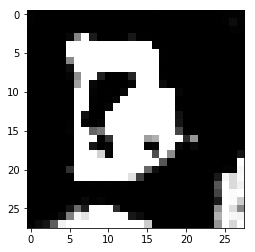

Estimated result : [[-12.85181999]]
i : 7100, at : 2017-09-07 11:10:59.101371


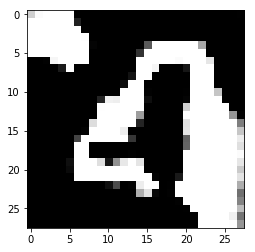

Estimated result : [[-34.96404648]]
i : 7200, at : 2017-09-07 11:11:07.817449


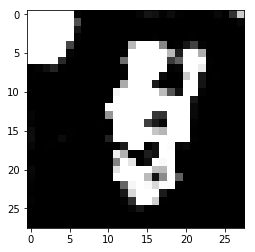

Estimated result : [[-2.44880247]]
i : 7300, at : 2017-09-07 11:11:16.496491


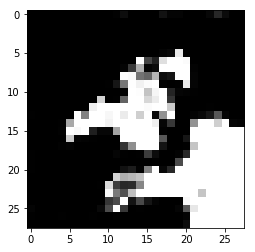

Estimated result : [[-17.75986481]]
i : 7400, at : 2017-09-07 11:11:25.046279


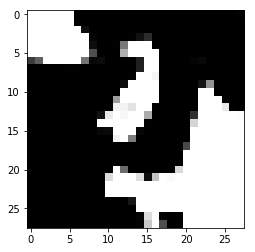

Estimated result : [[-25.9886837]]
i : 7500, at : 2017-09-07 11:11:33.667062


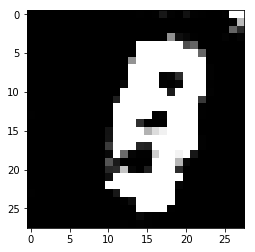

Estimated result : [[-14.2238102]]
i : 7600, at : 2017-09-07 11:11:42.337733


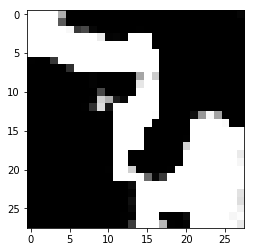

Estimated result : [[-3.12432528]]
i : 7700, at : 2017-09-07 11:11:51.013496


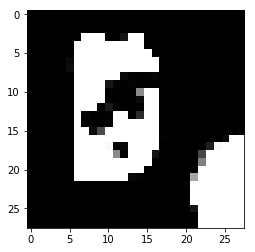

Estimated result : [[ 9.42381954]]
i : 7800, at : 2017-09-07 11:11:59.686024


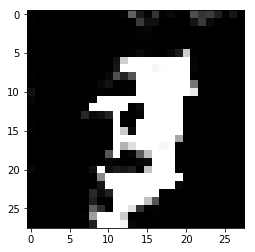

Estimated result : [[-20.03848267]]
i : 7900, at : 2017-09-07 11:12:08.366695


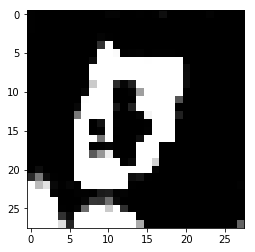

Estimated result : [[-17.53259659]]
i : 8000, at : 2017-09-07 11:12:17.141958


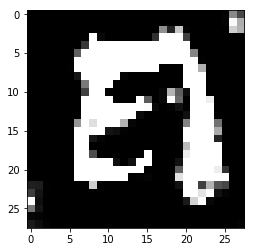

Estimated result : [[-13.10631657]]
i : 8100, at : 2017-09-07 11:12:25.789731


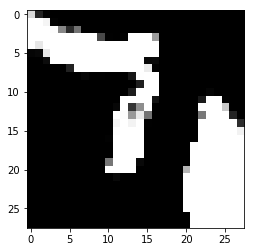

Estimated result : [[-24.32882881]]
i : 8200, at : 2017-09-07 11:12:34.424869


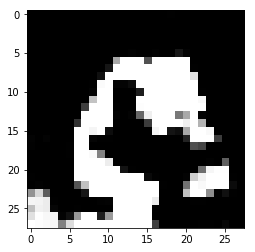

Estimated result : [[-18.50134277]]
i : 8300, at : 2017-09-07 11:12:43.416139


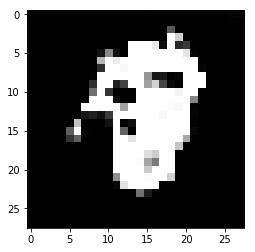

Estimated result : [[ 6.3812089]]
i : 8400, at : 2017-09-07 11:12:52.047360


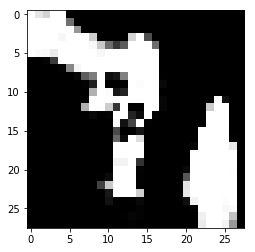

Estimated result : [[-5.37217093]]
i : 8500, at : 2017-09-07 11:13:00.700155


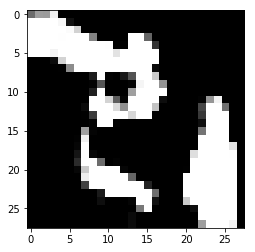

Estimated result : [[-14.03505421]]
i : 8600, at : 2017-09-07 11:13:09.301553


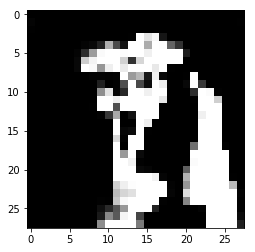

Estimated result : [[-21.6801548]]
i : 8700, at : 2017-09-07 11:13:17.971846


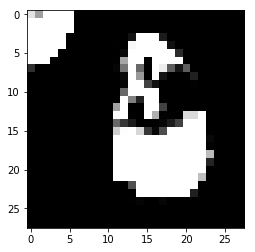

Estimated result : [[-1.33714211]]
i : 8800, at : 2017-09-07 11:13:26.619634


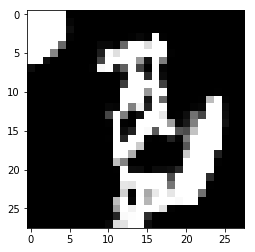

Estimated result : [[-5.44609451]]
i : 8900, at : 2017-09-07 11:13:35.372847


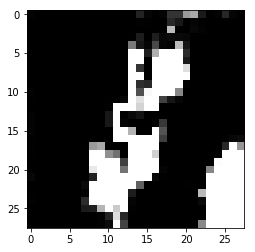

Estimated result : [[ 3.52153873]]
i : 9000, at : 2017-09-07 11:13:44.178825


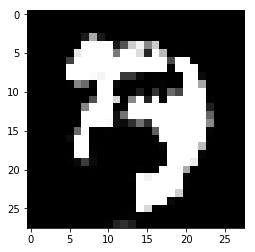

Estimated result : [[-15.61123848]]
i : 9100, at : 2017-09-07 11:13:52.927270


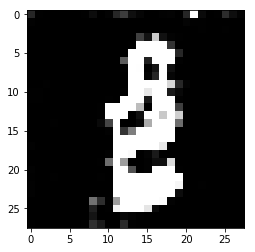

Estimated result : [[-4.59542561]]
i : 9200, at : 2017-09-07 11:14:01.711847


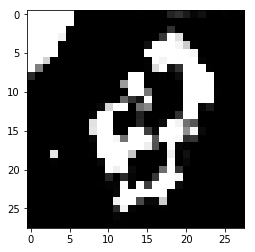

Estimated result : [[-30.73181915]]
i : 9300, at : 2017-09-07 11:14:10.443754


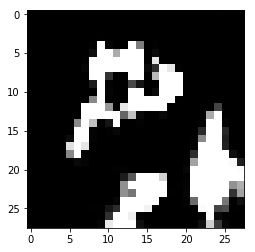

Estimated result : [[-42.16563416]]
i : 9400, at : 2017-09-07 11:14:19.191744


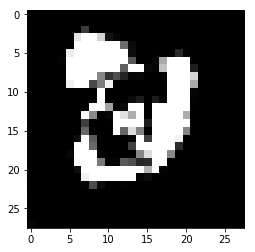

Estimated result : [[-18.04371834]]
i : 9500, at : 2017-09-07 11:14:27.930646


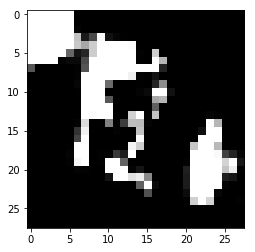

Estimated result : [[ 0.92197078]]
i : 9600, at : 2017-09-07 11:14:36.622126


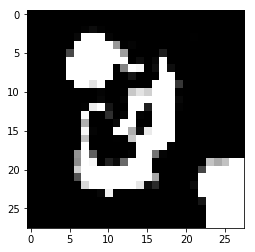

Estimated result : [[ 3.30699229]]
i : 9700, at : 2017-09-07 11:14:45.375385


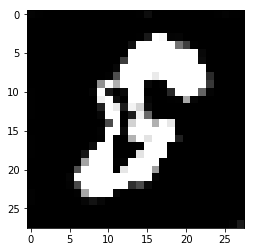

Estimated result : [[-10.94670868]]
i : 9800, at : 2017-09-07 11:14:54.350136


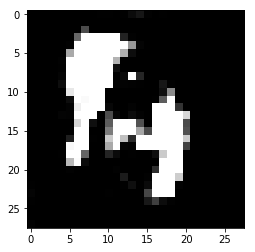

Estimated result : [[-19.49136925]]
i : 9900, at : 2017-09-07 11:15:03.066561


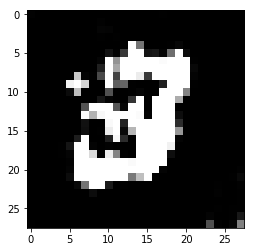

Estimated result : [[-25.79778481]]
i : 10000, at : 2017-09-07 11:15:11.867337


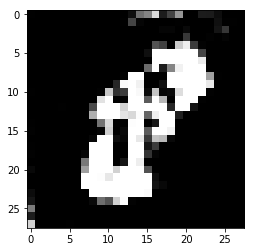

Estimated result : [[-22.980093]]
i : 10100, at : 2017-09-07 11:15:21.588856


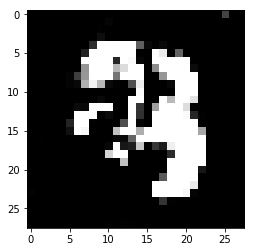

Estimated result : [[-10.42279816]]
i : 10200, at : 2017-09-07 11:15:30.317819


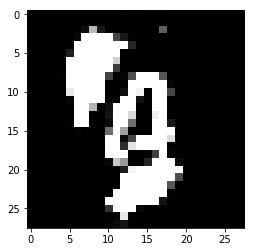

Estimated result : [[-4.84896517]]
i : 10300, at : 2017-09-07 11:15:39.158957


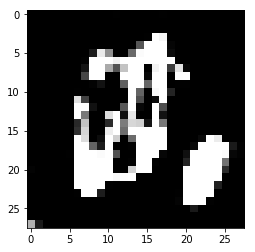

Estimated result : [[-10.5090332]]
i : 10400, at : 2017-09-07 11:15:47.980382


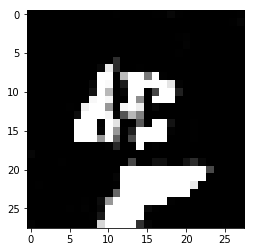

Estimated result : [[ 4.36932087]]
i : 10500, at : 2017-09-07 11:15:56.749911


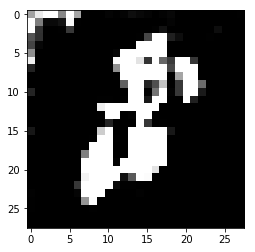

Estimated result : [[-54.46020889]]
i : 10600, at : 2017-09-07 11:16:05.483623


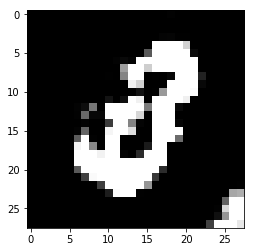

Estimated result : [[-39.77028656]]
i : 10700, at : 2017-09-07 11:16:14.303189


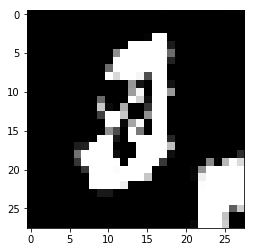

Estimated result : [[-19.26205635]]
i : 10800, at : 2017-09-07 11:16:23.049187


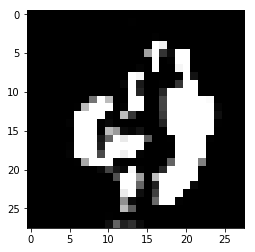

Estimated result : [[-23.29317474]]
i : 10900, at : 2017-09-07 11:16:31.766506


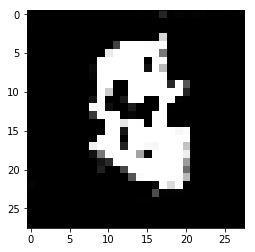

Estimated result : [[ 30.60964584]]
i : 11000, at : 2017-09-07 11:16:40.683662


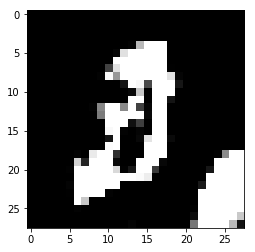

Estimated result : [[ 1.60041523]]
i : 11100, at : 2017-09-07 11:16:49.417444


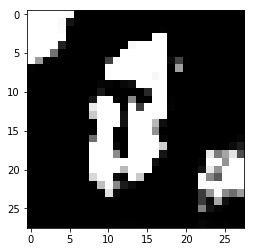

Estimated result : [[-154.04393005]]
i : 11200, at : 2017-09-07 11:16:58.227952


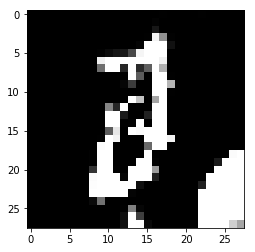

Estimated result : [[ 3.60510015]]
i : 11300, at : 2017-09-07 11:17:06.972785


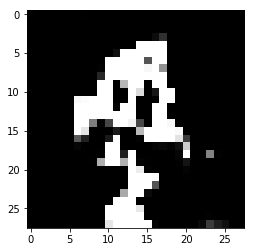

Estimated result : [[-51.20048523]]
i : 11400, at : 2017-09-07 11:17:15.892544


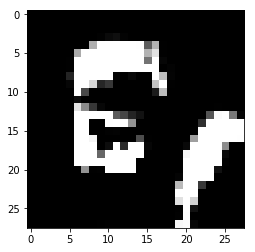

Estimated result : [[-22.45744896]]
i : 11500, at : 2017-09-07 11:17:25.026880


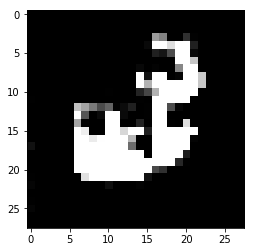

Estimated result : [[ 24.26992989]]
i : 11600, at : 2017-09-07 11:17:33.918177


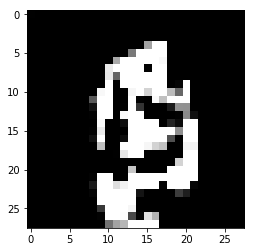

Estimated result : [[ 9.3950758]]
i : 11700, at : 2017-09-07 11:17:42.743334


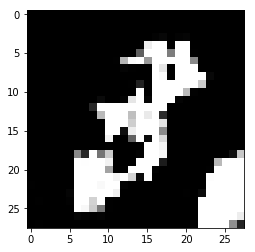

Estimated result : [[-17.18802452]]
i : 11800, at : 2017-09-07 11:17:51.596395


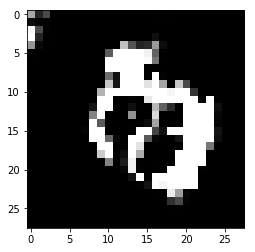

Estimated result : [[-54.7076149]]
i : 11900, at : 2017-09-07 11:18:00.481902


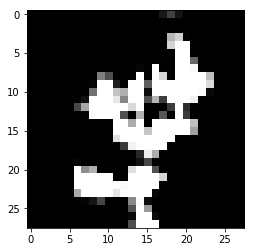

Estimated result : [[-10.60747528]]
i : 12000, at : 2017-09-07 11:18:09.339449


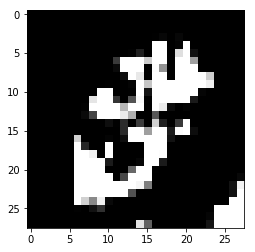

Estimated result : [[ 9.15960121]]
i : 12100, at : 2017-09-07 11:18:18.235666


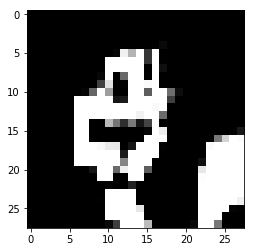

Estimated result : [[ 0.38733119]]
i : 12200, at : 2017-09-07 11:18:27.048529


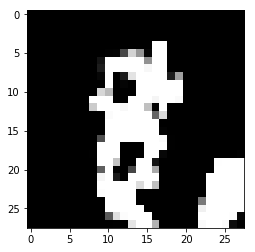

Estimated result : [[-9.74263954]]
i : 12300, at : 2017-09-07 11:18:35.863730


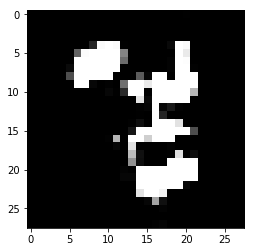

Estimated result : [[ 31.01762772]]
i : 12400, at : 2017-09-07 11:18:44.693690


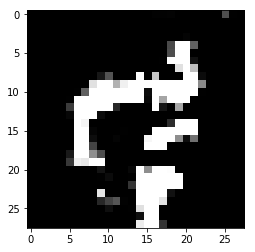

Estimated result : [[ 0.20169371]]
i : 12500, at : 2017-09-07 11:18:53.508777


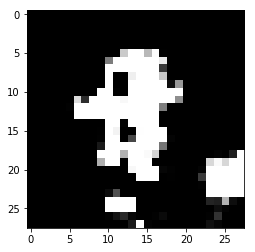

Estimated result : [[-20.95378304]]
i : 12600, at : 2017-09-07 11:19:02.490673


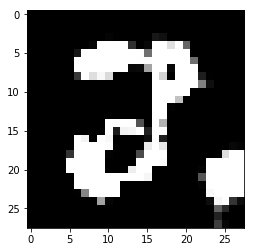

Estimated result : [[-24.75325203]]
i : 12700, at : 2017-09-07 11:19:11.389683


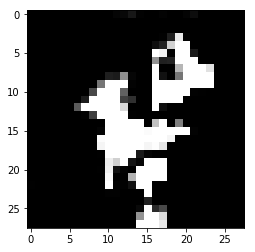

Estimated result : [[ 5.16919565]]
i : 12800, at : 2017-09-07 11:19:20.151052


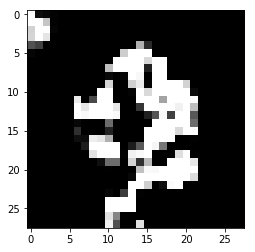

Estimated result : [[-93.41654968]]
i : 12900, at : 2017-09-07 11:19:28.977124


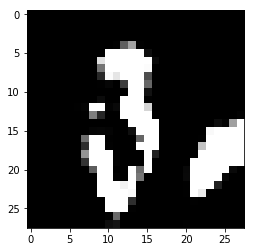

Estimated result : [[-10.02885628]]
i : 13000, at : 2017-09-07 11:19:37.800441


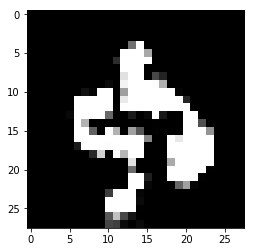

Estimated result : [[-33.83266449]]
i : 13100, at : 2017-09-07 11:19:46.759706


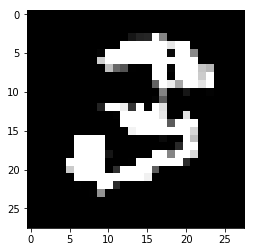

Estimated result : [[ 18.09036446]]
i : 13200, at : 2017-09-07 11:19:55.664117


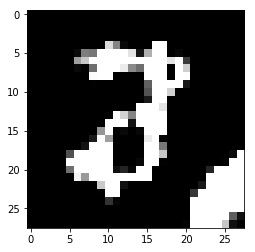

Estimated result : [[-70.4584198]]
i : 13300, at : 2017-09-07 11:20:04.607078


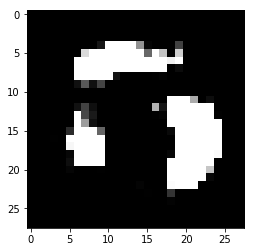

Estimated result : [[ 51.74969482]]
i : 13400, at : 2017-09-07 11:20:13.764107


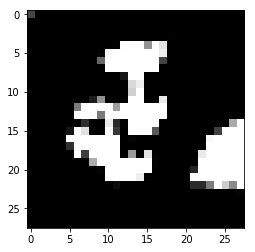

Estimated result : [[ 20.266222]]
i : 13500, at : 2017-09-07 11:20:22.737178


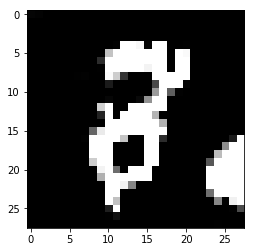

Estimated result : [[-63.6264267]]
i : 13600, at : 2017-09-07 11:20:31.614256


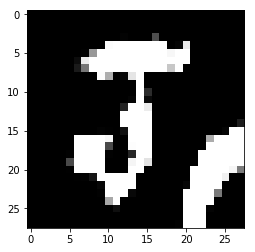

Estimated result : [[-28.51207542]]
i : 13700, at : 2017-09-07 11:20:40.478241


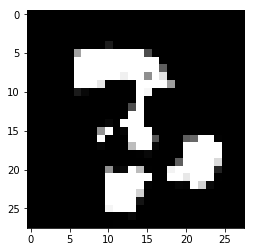

Estimated result : [[-23.13533401]]
i : 13800, at : 2017-09-07 11:20:49.436275


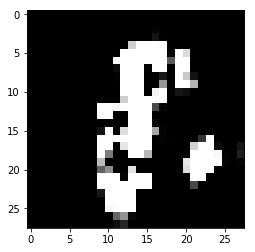

Estimated result : [[-63.7670784]]
i : 13900, at : 2017-09-07 11:20:58.286046


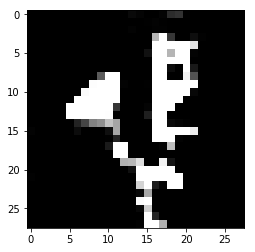

Estimated result : [[ 1.40813661]]
i : 14000, at : 2017-09-07 11:21:07.165514


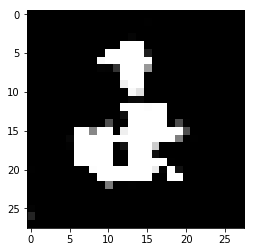

Estimated result : [[ 12.4722681]]
i : 14100, at : 2017-09-07 11:21:16.071257


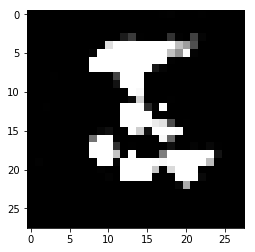

Estimated result : [[ 2.97025323]]
i : 14200, at : 2017-09-07 11:21:24.941088


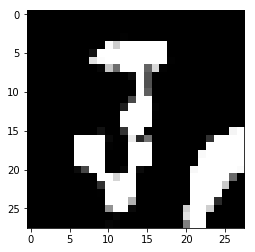

Estimated result : [[-10.59701347]]
i : 14300, at : 2017-09-07 11:21:33.788567


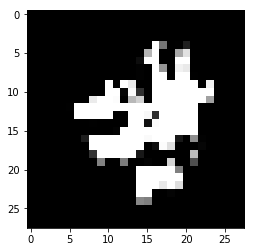

Estimated result : [[-29.04123878]]
i : 14400, at : 2017-09-07 11:21:42.787366


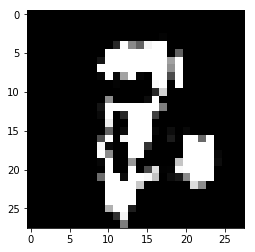

Estimated result : [[-24.71111679]]
i : 14500, at : 2017-09-07 11:21:51.708445


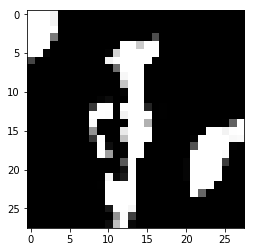

Estimated result : [[-66.76888275]]
i : 14600, at : 2017-09-07 11:22:00.614797


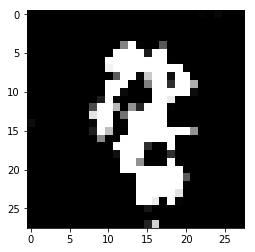

Estimated result : [[ 3.14113045]]
i : 14700, at : 2017-09-07 11:22:09.614034


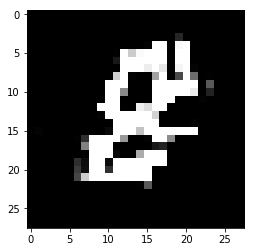

Estimated result : [[-29.62417221]]
i : 14800, at : 2017-09-07 11:22:18.559884


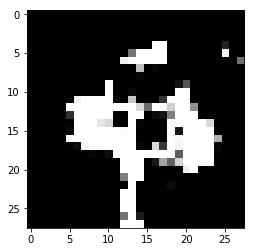

Estimated result : [[-17.30800247]]
i : 14900, at : 2017-09-07 11:22:27.551540


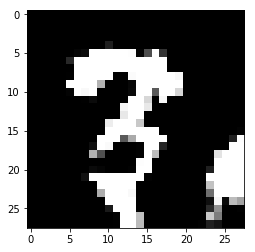

Estimated result : [[-15.9352169]]
i : 15000, at : 2017-09-07 11:22:36.491596


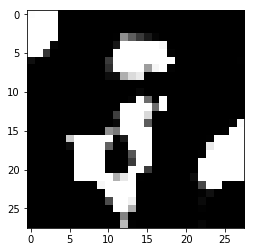

Estimated result : [[-19.85630035]]
i : 15100, at : 2017-09-07 11:22:45.488658


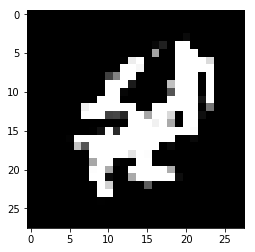

Estimated result : [[-52.82140732]]
i : 15200, at : 2017-09-07 11:22:54.351395


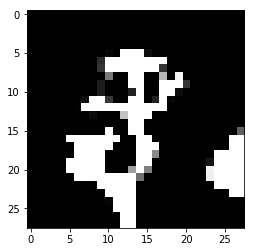

Estimated result : [[ 0.77953041]]
i : 15300, at : 2017-09-07 11:23:03.246566


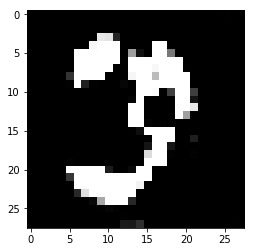

Estimated result : [[-2.15573454]]
i : 15400, at : 2017-09-07 11:23:12.212117


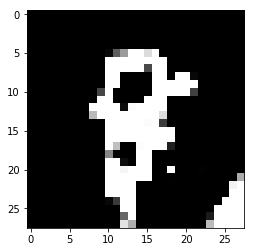

Estimated result : [[ 34.82120514]]
i : 15500, at : 2017-09-07 11:23:21.151649


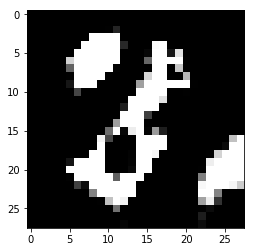

Estimated result : [[-45.53172302]]
i : 15600, at : 2017-09-07 11:23:30.400399


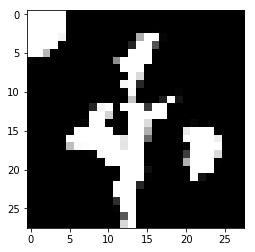

Estimated result : [[ 12.39755344]]
i : 15700, at : 2017-09-07 11:23:39.332614


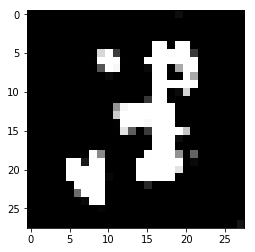

Estimated result : [[-13.98264599]]
i : 15800, at : 2017-09-07 11:23:48.398478


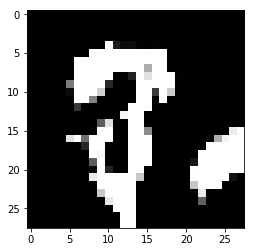

Estimated result : [[-71.61377716]]
i : 15900, at : 2017-09-07 11:23:57.336147


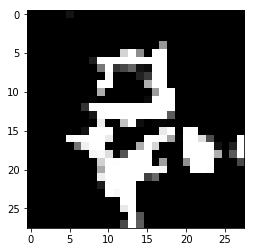

Estimated result : [[-117.8015213]]
i : 16000, at : 2017-09-07 11:24:06.309132


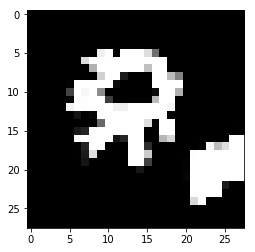

Estimated result : [[ 3.60237741]]
i : 16100, at : 2017-09-07 11:24:15.292188


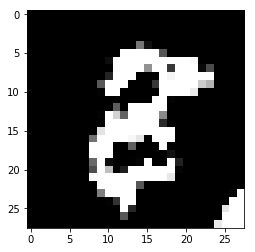

Estimated result : [[-30.81295204]]
i : 16200, at : 2017-09-07 11:24:24.278666


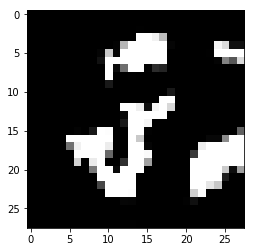

Estimated result : [[-72.11232758]]
i : 16300, at : 2017-09-07 11:24:33.330495


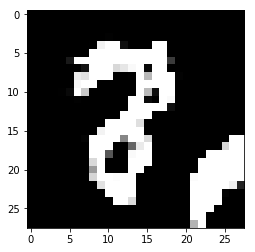

Estimated result : [[-12.05272484]]
i : 16400, at : 2017-09-07 11:24:42.525310


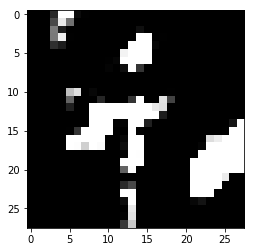

Estimated result : [[-61.49680328]]
i : 16500, at : 2017-09-07 11:24:51.522941


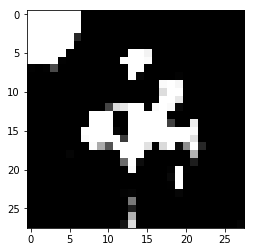

Estimated result : [[-85.94433594]]
i : 16600, at : 2017-09-07 11:25:00.511252


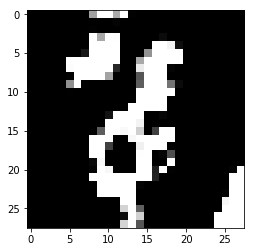

Estimated result : [[-34.60838318]]
i : 16700, at : 2017-09-07 11:25:09.516929


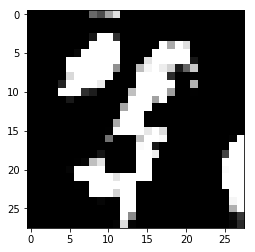

Estimated result : [[-34.45852661]]
i : 16800, at : 2017-09-07 11:25:18.540894


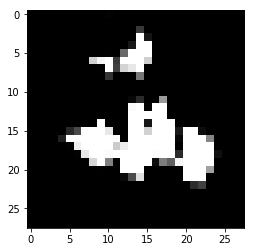

Estimated result : [[-61.25308228]]
i : 16900, at : 2017-09-07 11:25:27.508914


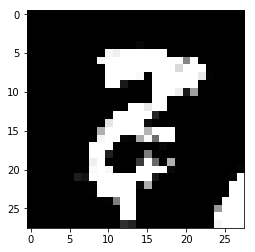

Estimated result : [[-11.74904442]]
i : 17000, at : 2017-09-07 11:25:36.617298


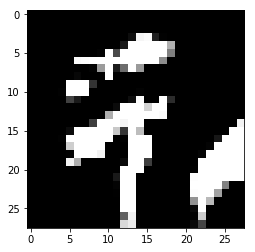

Estimated result : [[-28.67988014]]
i : 17100, at : 2017-09-07 11:25:45.746997


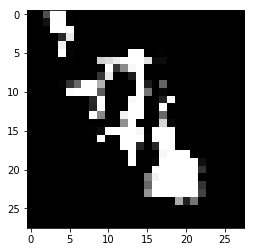

Estimated result : [[-98.60075378]]
i : 17200, at : 2017-09-07 11:25:54.856460


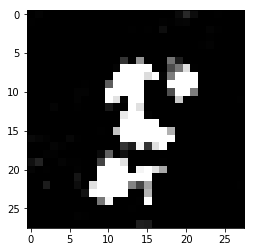

Estimated result : [[ 1.11953592]]
i : 17300, at : 2017-09-07 11:26:03.892281


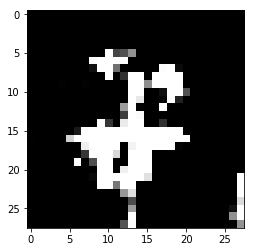

Estimated result : [[-106.43835449]]
i : 17400, at : 2017-09-07 11:26:12.992452


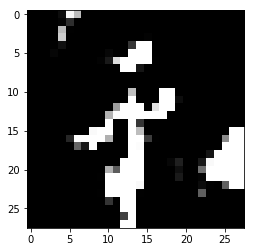

Estimated result : [[-85.85250092]]
i : 17500, at : 2017-09-07 11:26:22.088914


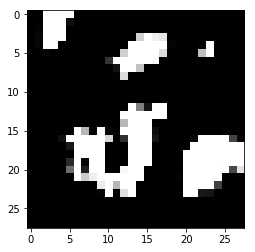

Estimated result : [[-42.36735916]]
i : 17600, at : 2017-09-07 11:26:31.156720


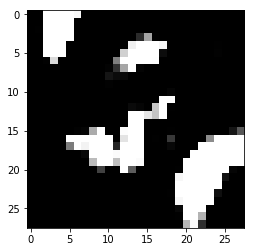

Estimated result : [[-69.13844299]]
i : 17700, at : 2017-09-07 11:26:40.190504


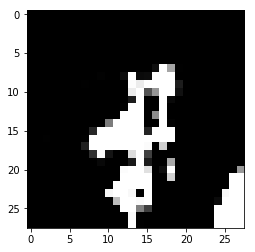

Estimated result : [[ 27.75108337]]
i : 17800, at : 2017-09-07 11:26:49.252448


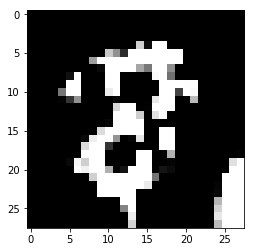

Estimated result : [[ 4.05235815]]
i : 17900, at : 2017-09-07 11:26:58.283926


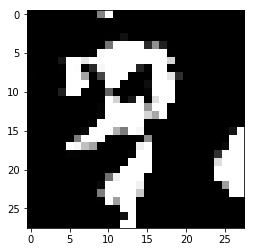

Estimated result : [[ 13.13673878]]
i : 18000, at : 2017-09-07 11:27:07.449996


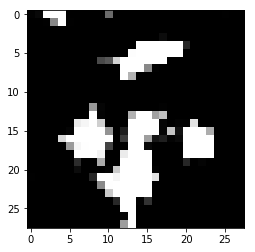

Estimated result : [[-73.3221283]]
i : 18100, at : 2017-09-07 11:27:16.978587


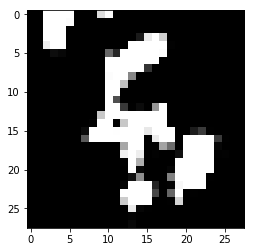

Estimated result : [[ 44.83808517]]
i : 18200, at : 2017-09-07 11:27:26.209486


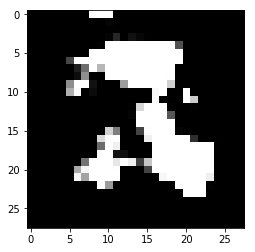

Estimated result : [[-72.24380493]]
i : 18300, at : 2017-09-07 11:27:35.318183


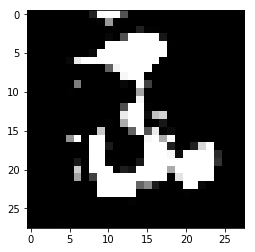

Estimated result : [[-54.91400146]]
i : 18400, at : 2017-09-07 11:27:44.591881


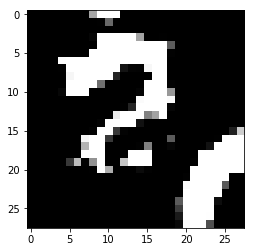

Estimated result : [[-21.83992577]]
i : 18500, at : 2017-09-07 11:27:53.776252


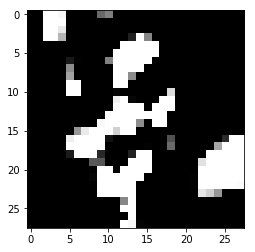

Estimated result : [[-121.37466431]]
i : 18600, at : 2017-09-07 11:28:02.885439


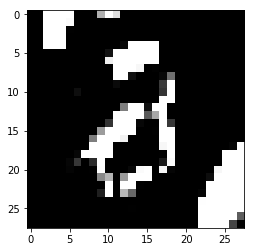

Estimated result : [[ 35.52033615]]
i : 18700, at : 2017-09-07 11:28:11.974976


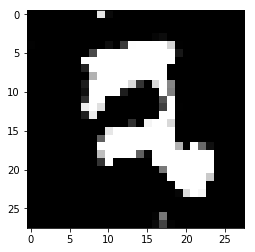

Estimated result : [[ 18.47288704]]
i : 18800, at : 2017-09-07 11:28:21.035542


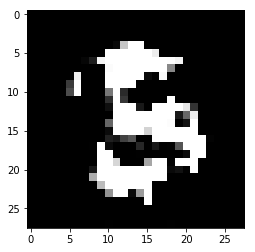

Estimated result : [[-40.45136642]]
i : 18900, at : 2017-09-07 11:28:30.189618


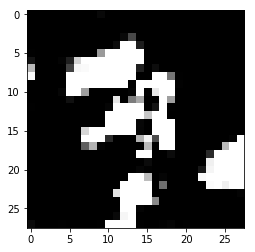

Estimated result : [[-76.42219543]]
i : 19000, at : 2017-09-07 11:28:39.293863


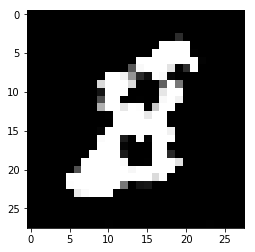

Estimated result : [[-29.78331947]]
i : 19100, at : 2017-09-07 11:28:48.388549


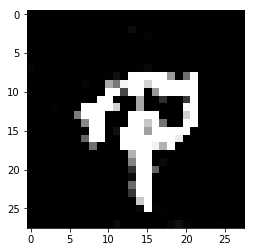

Estimated result : [[-6.94132423]]
i : 19200, at : 2017-09-07 11:28:57.500358


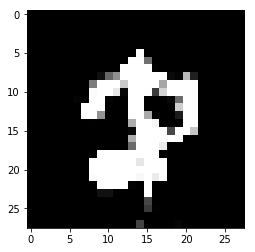

Estimated result : [[ 32.67045212]]
i : 19300, at : 2017-09-07 11:29:06.670308


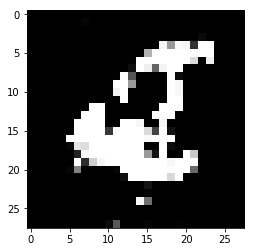

Estimated result : [[ 52.69987869]]
i : 19400, at : 2017-09-07 11:29:15.795715


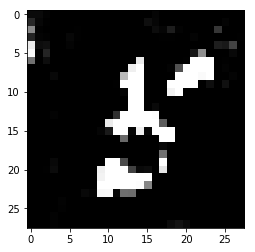

Estimated result : [[-67.71695709]]
i : 19500, at : 2017-09-07 11:29:24.887125


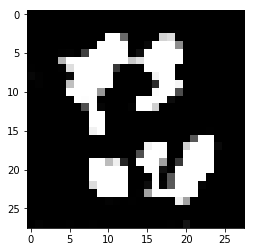

Estimated result : [[-89.47488403]]
i : 19600, at : 2017-09-07 11:29:33.991618


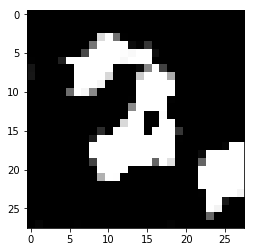

Estimated result : [[ 1.34434223]]
i : 19700, at : 2017-09-07 11:29:43.262399


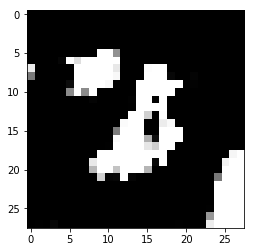

Estimated result : [[-17.54573441]]
i : 19800, at : 2017-09-07 11:29:52.307326


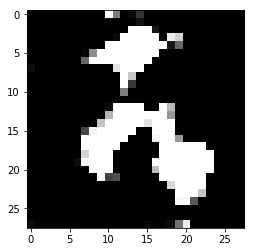

Estimated result : [[-51.60741425]]
i : 19900, at : 2017-09-07 11:30:01.575772


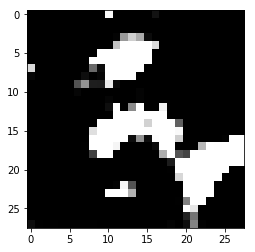

Estimated result : [[-69.81253815]]
i : 20000, at : 2017-09-07 11:30:10.711665


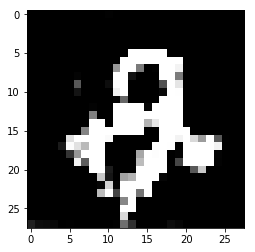

Estimated result : [[ 64.65674591]]
i : 20100, at : 2017-09-07 11:30:21.568826


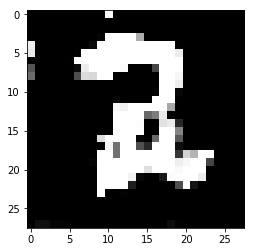

Estimated result : [[ 40.38230896]]
i : 20200, at : 2017-09-07 11:30:30.870986


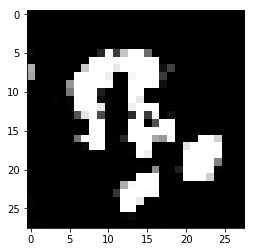

Estimated result : [[-21.74576378]]
i : 20300, at : 2017-09-07 11:30:40.014764


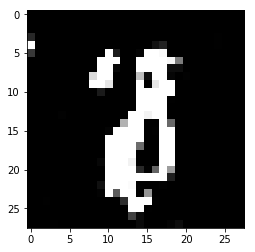

Estimated result : [[ 12.99023819]]
i : 20400, at : 2017-09-07 11:30:49.250025


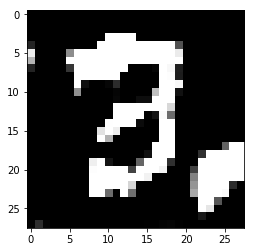

Estimated result : [[-16.61362076]]
i : 20500, at : 2017-09-07 11:30:58.551504


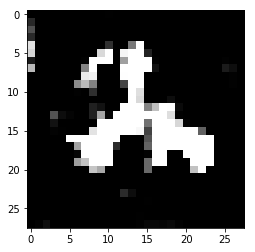

Estimated result : [[-12.63660717]]
i : 20600, at : 2017-09-07 11:31:07.722285


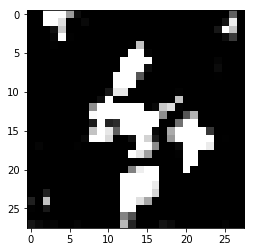

Estimated result : [[-10.50755882]]
i : 20700, at : 2017-09-07 11:31:17.245737


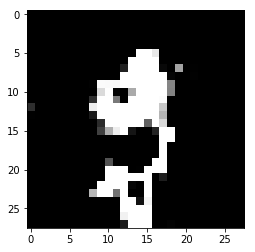

Estimated result : [[ 4.41990471]]
i : 20800, at : 2017-09-07 11:31:26.419514


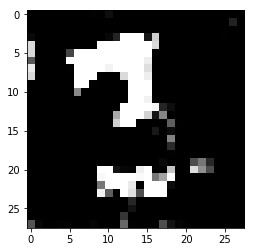

Estimated result : [[ 2.51910591]]
i : 20900, at : 2017-09-07 11:31:35.608858


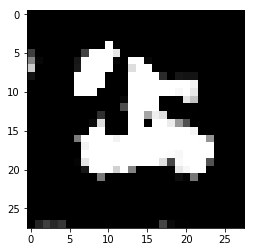

Estimated result : [[ 59.14300919]]
i : 21000, at : 2017-09-07 11:31:45.067686


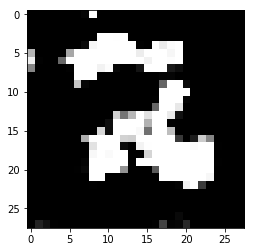

Estimated result : [[ 54.35171127]]
i : 21100, at : 2017-09-07 11:31:54.381861


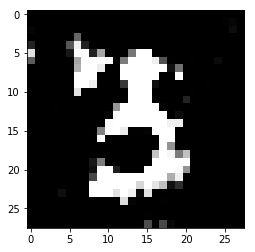

Estimated result : [[ 58.68102264]]
i : 21200, at : 2017-09-07 11:32:03.545985


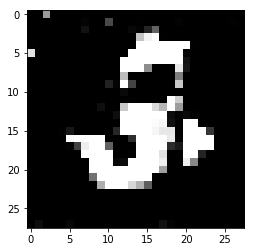

Estimated result : [[ 6.15599442]]
i : 21300, at : 2017-09-07 11:32:12.861507


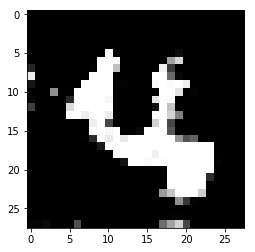

Estimated result : [[ 77.81292725]]
i : 21400, at : 2017-09-07 11:32:22.117972


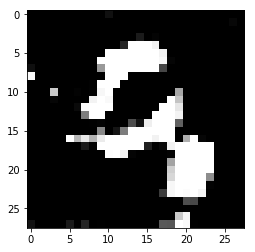

Estimated result : [[ 14.18268871]]
i : 21500, at : 2017-09-07 11:32:31.407142


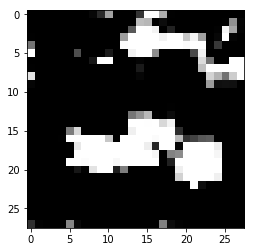

Estimated result : [[ 66.32059479]]
i : 21600, at : 2017-09-07 11:32:40.643431


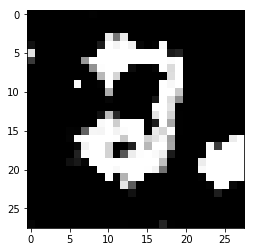

Estimated result : [[-32.688591]]
i : 21700, at : 2017-09-07 11:32:49.855611


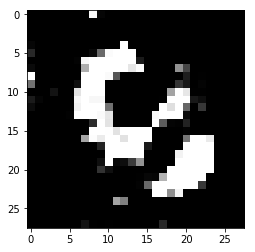

Estimated result : [[ 5.62737083]]
i : 21800, at : 2017-09-07 11:32:59.109632


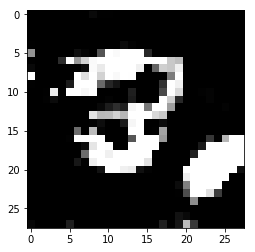

Estimated result : [[-93.37628174]]
i : 21900, at : 2017-09-07 11:33:08.342440


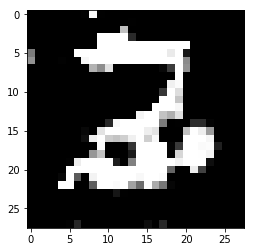

Estimated result : [[ 14.04446411]]
i : 22000, at : 2017-09-07 11:33:17.603756


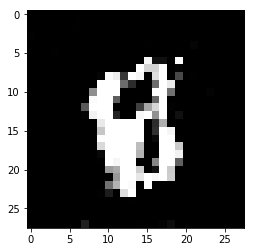

Estimated result : [[ 7.71136808]]
i : 22100, at : 2017-09-07 11:33:26.932026


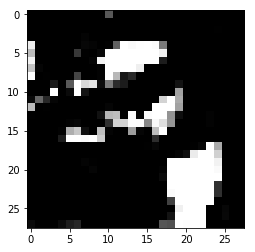

Estimated result : [[-12.50982475]]
i : 22200, at : 2017-09-07 11:33:36.196773


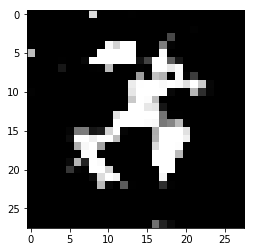

Estimated result : [[ 31.78130722]]
i : 22300, at : 2017-09-07 11:33:45.479042


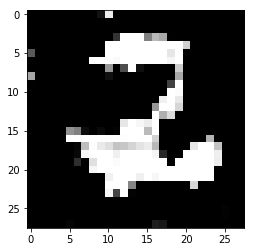

Estimated result : [[ 28.93360329]]
i : 22400, at : 2017-09-07 11:33:54.750603


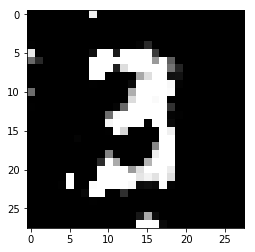

Estimated result : [[-19.94179535]]
i : 22500, at : 2017-09-07 11:34:03.972965


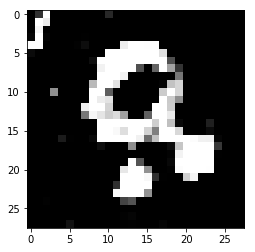

Estimated result : [[-47.29125977]]
i : 22600, at : 2017-09-07 11:34:13.269418


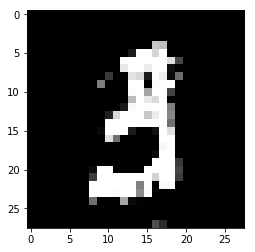

Estimated result : [[ 38.47605133]]
i : 22700, at : 2017-09-07 11:34:22.532854


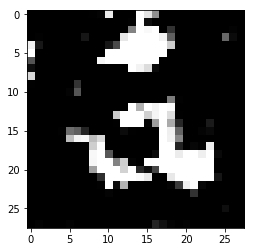

Estimated result : [[ 9.37447357]]
i : 22800, at : 2017-09-07 11:34:31.854155


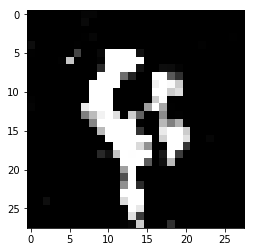

Estimated result : [[-15.01970959]]
i : 22900, at : 2017-09-07 11:34:41.273579


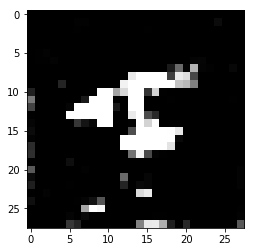

Estimated result : [[-55.74735641]]
i : 23000, at : 2017-09-07 11:34:50.585133


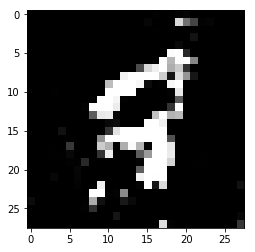

Estimated result : [[-41.8225441]]
i : 23100, at : 2017-09-07 11:34:59.890145


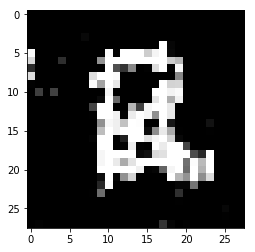

Estimated result : [[-26.27698898]]
i : 23200, at : 2017-09-07 11:35:09.190865


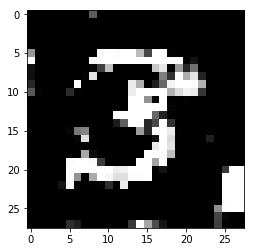

Estimated result : [[-19.90086555]]
i : 23300, at : 2017-09-07 11:35:18.461351


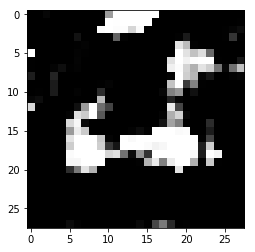

Estimated result : [[ 105.12781525]]
i : 23400, at : 2017-09-07 11:35:27.748671


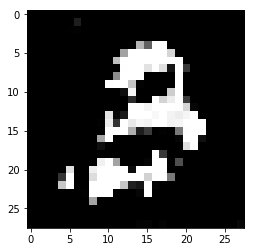

Estimated result : [[-19.47402191]]
i : 23500, at : 2017-09-07 11:35:37.059310


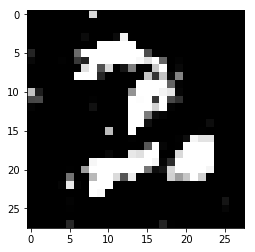

Estimated result : [[ 28.56572723]]
i : 23600, at : 2017-09-07 11:35:46.397289


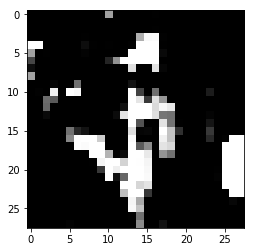

Estimated result : [[-15.27730846]]
i : 23700, at : 2017-09-07 11:35:55.781594


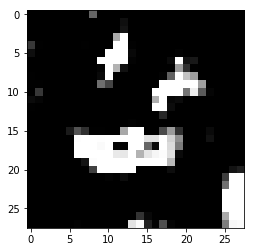

Estimated result : [[ 45.63167191]]
i : 23800, at : 2017-09-07 11:36:05.622943


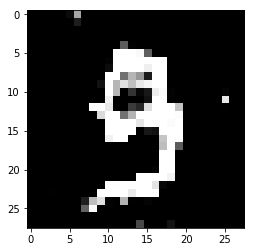

Estimated result : [[ 5.47891998]]
i : 23900, at : 2017-09-07 11:36:14.932896


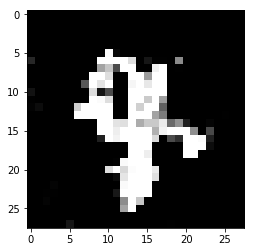

Estimated result : [[-16.60063934]]
i : 24000, at : 2017-09-07 11:36:24.453413


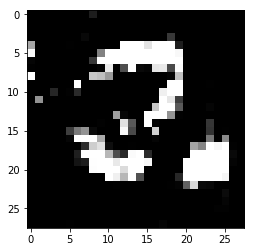

Estimated result : [[-109.91399384]]
i : 24100, at : 2017-09-07 11:36:33.949216


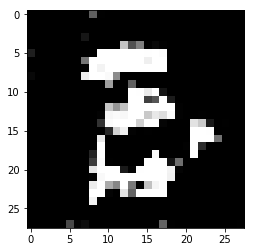

Estimated result : [[-3.79464769]]
i : 24200, at : 2017-09-07 11:36:43.324686


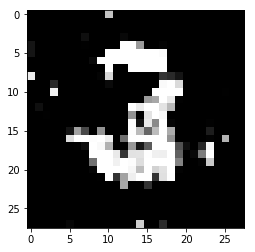

Estimated result : [[-50.84143448]]
i : 24300, at : 2017-09-07 11:36:52.680507


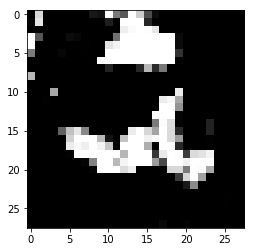

Estimated result : [[-44.21854782]]
i : 24400, at : 2017-09-07 11:37:02.140813


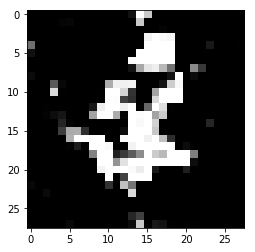

Estimated result : [[-13.75570107]]
i : 24500, at : 2017-09-07 11:37:11.510000


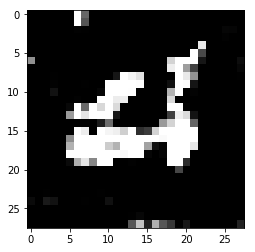

Estimated result : [[-36.21576691]]
i : 24600, at : 2017-09-07 11:37:20.982954


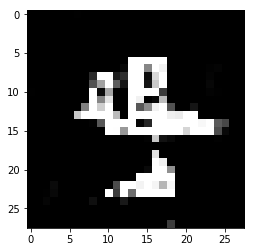

Estimated result : [[ 19.40641975]]
i : 24700, at : 2017-09-07 11:37:30.477607


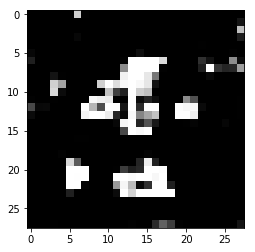

Estimated result : [[-109.18071747]]
i : 24800, at : 2017-09-07 11:37:39.886808


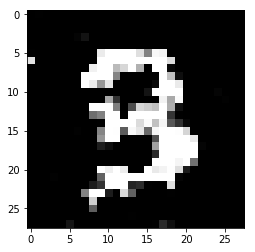

Estimated result : [[-18.89278412]]
i : 24900, at : 2017-09-07 11:37:49.389139


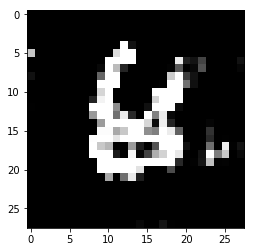

Estimated result : [[-32.55376816]]
i : 25000, at : 2017-09-07 11:37:58.753335


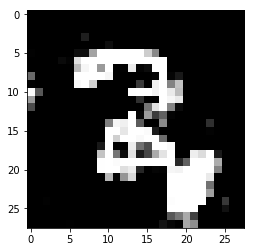

Estimated result : [[ 57.1435318]]
i : 25100, at : 2017-09-07 11:38:08.185093


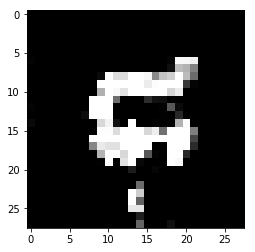

Estimated result : [[ 11.83118153]]
i : 25200, at : 2017-09-07 11:38:17.568277


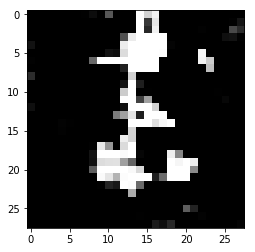

Estimated result : [[-42.55271149]]
i : 25300, at : 2017-09-07 11:38:27.178783


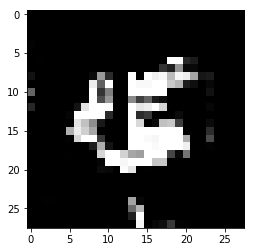

Estimated result : [[-47.23416901]]
i : 25400, at : 2017-09-07 11:38:36.663855


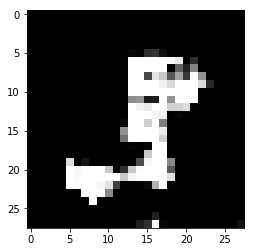

Estimated result : [[-55.57621002]]
i : 25500, at : 2017-09-07 11:38:46.099816


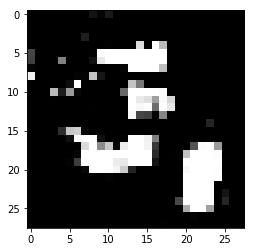

Estimated result : [[ 30.74546242]]
i : 25600, at : 2017-09-07 11:38:55.611249


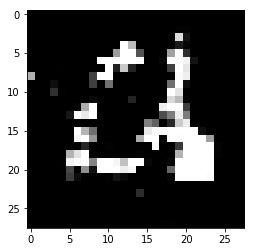

Estimated result : [[-86.10401917]]
i : 25700, at : 2017-09-07 11:39:05.023782


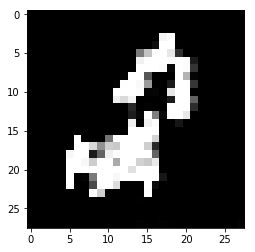

Estimated result : [[-38.36214447]]
i : 25800, at : 2017-09-07 11:39:14.432334


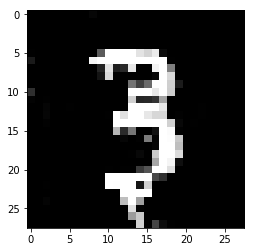

Estimated result : [[-45.80250549]]
i : 25900, at : 2017-09-07 11:39:23.973039


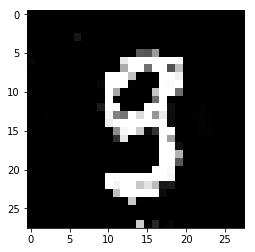

Estimated result : [[ 0.35773814]]
i : 26000, at : 2017-09-07 11:39:33.377137


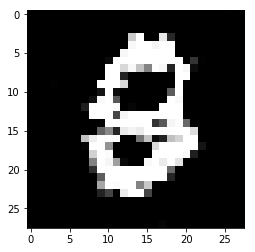

Estimated result : [[-23.14663696]]
i : 26100, at : 2017-09-07 11:39:42.856573


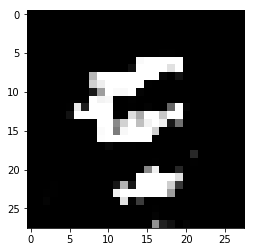

Estimated result : [[-13.13137341]]
i : 26200, at : 2017-09-07 11:39:52.556473


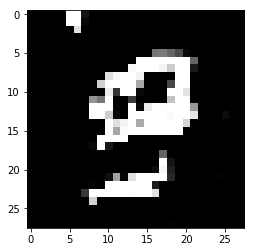

Estimated result : [[-61.35020828]]
i : 26300, at : 2017-09-07 11:40:02.145263


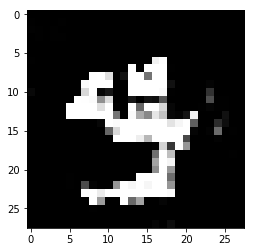

Estimated result : [[-34.42474365]]
i : 26400, at : 2017-09-07 11:40:11.600246


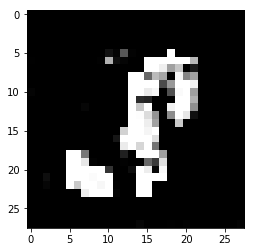

Estimated result : [[-18.32251358]]
i : 26500, at : 2017-09-07 11:40:21.055855


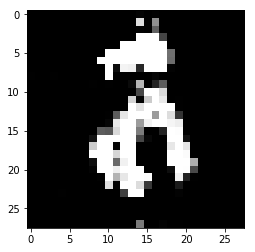

Estimated result : [[ 77.49038696]]
i : 26600, at : 2017-09-07 11:40:30.543973


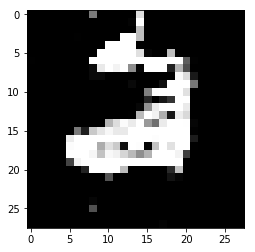

Estimated result : [[ 0.68462342]]
i : 26700, at : 2017-09-07 11:40:40.040456


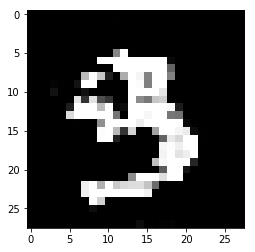

Estimated result : [[-12.65112495]]


KeyboardInterrupt: 

In [19]:
for i in range(100000):
    # train discriminator
    z_batch = np.random.normal(0, 1, [batch_size, z_dimensions])
    real_image_batch = mnist_data.train.next_batch(batch_size)[0].reshape([batch_size, 28, 28, 1])
    _, _, dLossReal, dLossFake = sess.run([d_trainer_real, d_trainer_fake, d_loss_real, d_loss_fake], 
                                          feed_dict={x_placeholder:real_image_batch, z_placeholder:z_batch})
    
    # train generator
    z_batch = np.random.normal(0, 1, [batch_size, z_dimensions])
    _ = sess.run(g_trainer, feed_dict={z_placeholder:z_batch})
    
    if i % 10 == 0:
        # Update tensorboard
        z_batch = np.random.normal(0, 1, [batch_size, z_dimensions])
        summary = sess.run(merged, feed_dict={z_placeholder:z_batch, x_placeholder:real_image_batch})
        writer.add_summary(summary, i)
        
    if i % 100 == 0:
        # Every 100 iters, show generated images
        print("i : {}, at : {}".format(i, datetime.datetime.now()))
        z_batch = np.random.normal(0, 1, [1, z_dimensions])
        generating_image_tensor = generator(z_placeholder, 1, z_dimensions)
        generated_image = sess.run(generating_image_tensor, feed_dict={z_placeholder:z_batch})
        plt.imshow(generated_image[0].reshape([28,28]), cmap='gray')
        plt.show()
        
        # Show discriminator's estimate
        im = generated_image[0].reshape([1, 28, 28, 1])
        discriminator_result_tensor = discriminator(x_placeholder)
        estimate_result = sess.run(discriminator_result_tensor, feed_dict={x_placeholder:im})
        print("Estimated result : {}".format(estimate_result))
    
    if i % 10000 == 0:
        # Save weights
        saver.save(sess, 'pretrained-model/pretrained_gan.ckpt', global_step=i)

## After training, we can load weights by restore

In [18]:
saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, 'pretrained-model/pretrained_gan.ckpt')
    z_batch = np.random.normal(0, 1, [10, z_dimensions])
    z_placeholder = tf.placeholder(tf.float32, [None, z_dimensions], name='z_placeholder')
    generated_images = generator(z_placeholder, 10, z_dimensions)
    images = sess.run(generated_images, feed_dict={z_placeholder:z_batch})
    for i in range(10):
        plt.imshow(images[i].reshpae([28, 28]), cmap='gray')
        plt.show()

INFO:tensorflow:Restoring parameters from pretrained-model/pretrained_gan.ckpt


NotFoundError: Unsuccessful TensorSliceReader constructor: Failed to find any matching files for pretrained-model/pretrained_gan.ckpt
	 [[Node: save/RestoreV2_21 = RestoreV2[dtypes=[DT_FLOAT], _device="/job:localhost/replica:0/task:0/cpu:0"](_arg_save/Const_0_0, save/RestoreV2_21/tensor_names, save/RestoreV2_21/shape_and_slices)]]
	 [[Node: save/RestoreV2_12/_133 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/gpu:0", send_device="/job:localhost/replica:0/task:0/cpu:0", send_device_incarnation=1, tensor_name="edge_294_save/RestoreV2_12", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/gpu:0"]()]]

Caused by op 'save/RestoreV2_21', defined at:
  File "/home/soma/anaconda3/envs/venvOpenCV3/lib/python3.5/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/soma/anaconda3/envs/venvOpenCV3/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/soma/anaconda3/envs/venvOpenCV3/lib/python3.5/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/soma/anaconda3/envs/venvOpenCV3/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/soma/anaconda3/envs/venvOpenCV3/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/home/soma/anaconda3/envs/venvOpenCV3/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/soma/anaconda3/envs/venvOpenCV3/lib/python3.5/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/home/soma/anaconda3/envs/venvOpenCV3/lib/python3.5/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/soma/anaconda3/envs/venvOpenCV3/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/soma/anaconda3/envs/venvOpenCV3/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/soma/anaconda3/envs/venvOpenCV3/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/soma/anaconda3/envs/venvOpenCV3/lib/python3.5/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/soma/anaconda3/envs/venvOpenCV3/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/soma/anaconda3/envs/venvOpenCV3/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/soma/anaconda3/envs/venvOpenCV3/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/soma/anaconda3/envs/venvOpenCV3/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/soma/anaconda3/envs/venvOpenCV3/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/soma/anaconda3/envs/venvOpenCV3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2698, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/soma/anaconda3/envs/venvOpenCV3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2802, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/soma/anaconda3/envs/venvOpenCV3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-18-a2b1622e5f8f>", line 1, in <module>
    saver = tf.train.Saver()
  File "/home/soma/anaconda3/envs/venvOpenCV3/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 1139, in __init__
    self.build()
  File "/home/soma/anaconda3/envs/venvOpenCV3/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 1170, in build
    restore_sequentially=self._restore_sequentially)
  File "/home/soma/anaconda3/envs/venvOpenCV3/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 691, in build
    restore_sequentially, reshape)
  File "/home/soma/anaconda3/envs/venvOpenCV3/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 407, in _AddRestoreOps
    tensors = self.restore_op(filename_tensor, saveable, preferred_shard)
  File "/home/soma/anaconda3/envs/venvOpenCV3/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 247, in restore_op
    [spec.tensor.dtype])[0])
  File "/home/soma/anaconda3/envs/venvOpenCV3/lib/python3.5/site-packages/tensorflow/python/ops/gen_io_ops.py", line 640, in restore_v2
    dtypes=dtypes, name=name)
  File "/home/soma/anaconda3/envs/venvOpenCV3/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "/home/soma/anaconda3/envs/venvOpenCV3/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2506, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/soma/anaconda3/envs/venvOpenCV3/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1269, in __init__
    self._traceback = _extract_stack()

NotFoundError (see above for traceback): Unsuccessful TensorSliceReader constructor: Failed to find any matching files for pretrained-model/pretrained_gan.ckpt
	 [[Node: save/RestoreV2_21 = RestoreV2[dtypes=[DT_FLOAT], _device="/job:localhost/replica:0/task:0/cpu:0"](_arg_save/Const_0_0, save/RestoreV2_21/tensor_names, save/RestoreV2_21/shape_and_slices)]]
	 [[Node: save/RestoreV2_12/_133 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/gpu:0", send_device="/job:localhost/replica:0/task:0/cpu:0", send_device_incarnation=1, tensor_name="edge_294_save/RestoreV2_12", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/gpu:0"]()]]
